In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd

In [4]:
import celloracle as co

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

In [5]:
import sys
sys.path.append('../src')

import numpy as np
from utils import process_adata, filter_clusters

import scanpy as sc 

In [ ]:
# adata = sc.read_h5ad('./.cache/adata_train.h5ad')
# adata

adata = sc.read_h5ad('../data/slideseq/day3_1.h5ad')
adata.obs['rctd_cluster'].value_counts()

In [6]:
adata = filter_clusters(adata, c=[5, 6])
adata = process_adata(adata)
adata.shape

(12475, 13217)

... storing 'rctd_cluster' as categorical


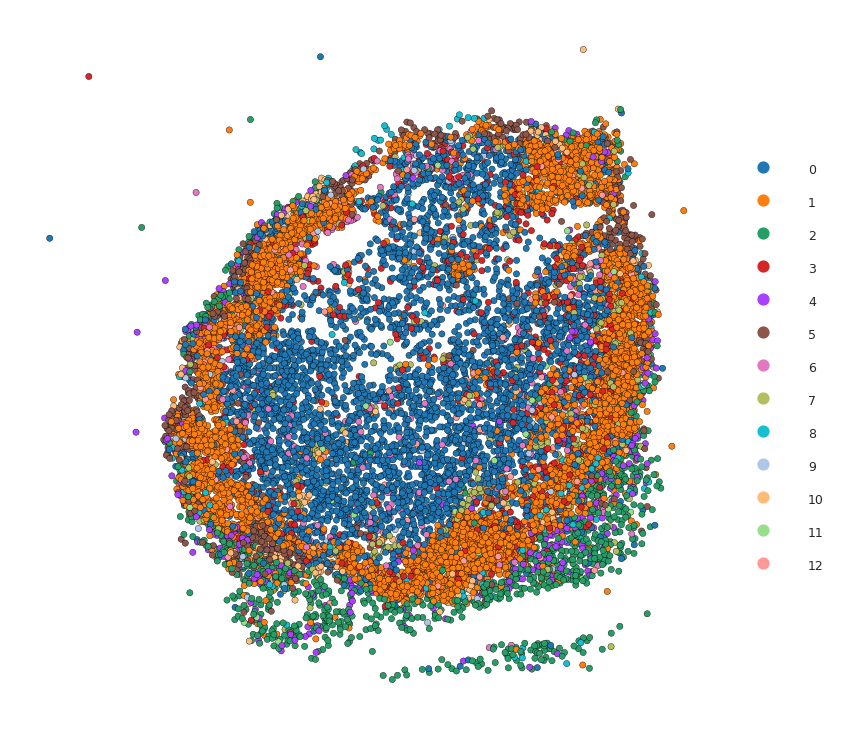

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, color='cluster', basis="spatial", s=25, show=False, edgecolor='black', linewidth=0.15)

fig = plt.gcf()
ax = plt.gca()

# Adjust the legend size
legend = ax.get_legend()
for text in legend.get_texts():
    text.set_fontsize(5)

for handle in legend.legendHandles:
    handle._sizes = [15]

plt.title('')
plt.axis('off')
plt.show()

In [8]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

2024-09-07 13:33:57.940742: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 13:33:58.217152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 13:33:58.445785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 13:33:58.479578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 13:33:58.936650: I tensorflow/core/platform/cpu_feature_guar

CPU times: user 57 s, sys: 2.07 s, total: 59 s
Wall time: 1min 4s


In [9]:
sc.tl.paga(adata, groups='rctd_cluster')

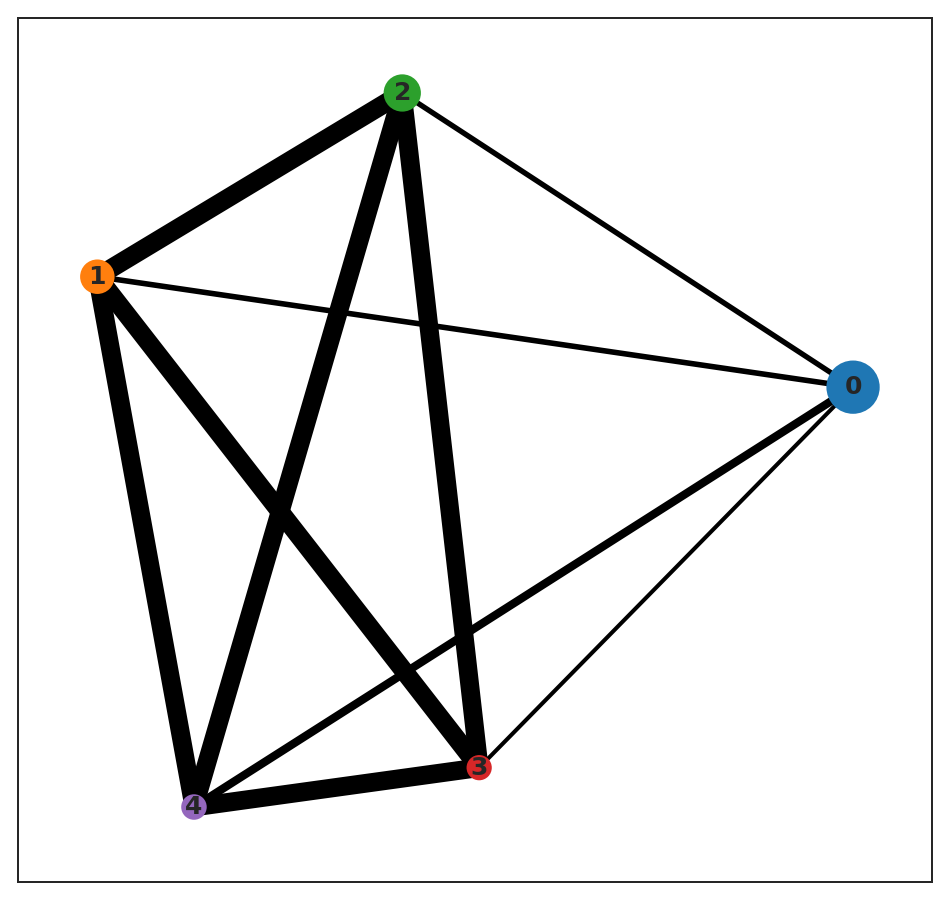

In [10]:
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [11]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

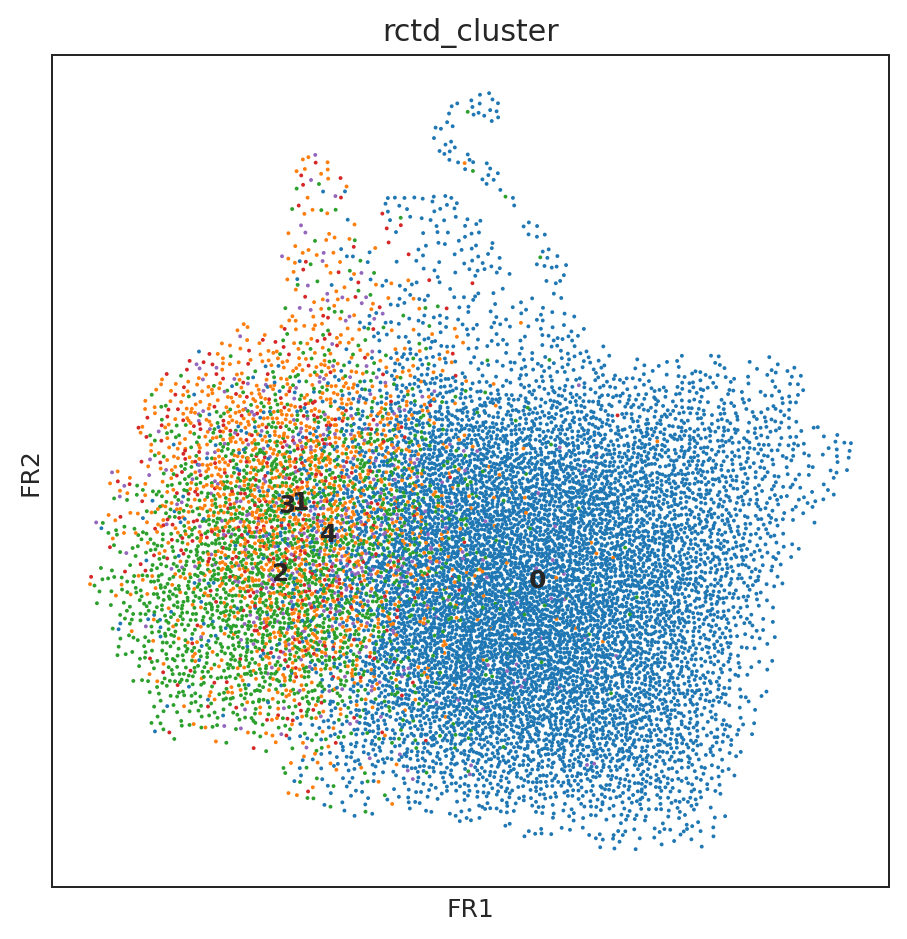

In [12]:
%matplotlib inline
sc.pl.draw_graph(adata, color='rctd_cluster', legend_loc='on data')

In [13]:
oracle = co.Oracle()

In [14]:
adata.layers["raw_count"].toarray().sum(0)

array([ 52.25238 ,  24.179808,  25.366808, ..., 198.11688 , 200.44206 ,
       160.90308 ], dtype=float32)

In [15]:
adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="rctd_cluster",
    embedding_name="X_draw_graph_fr"
)

13217 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


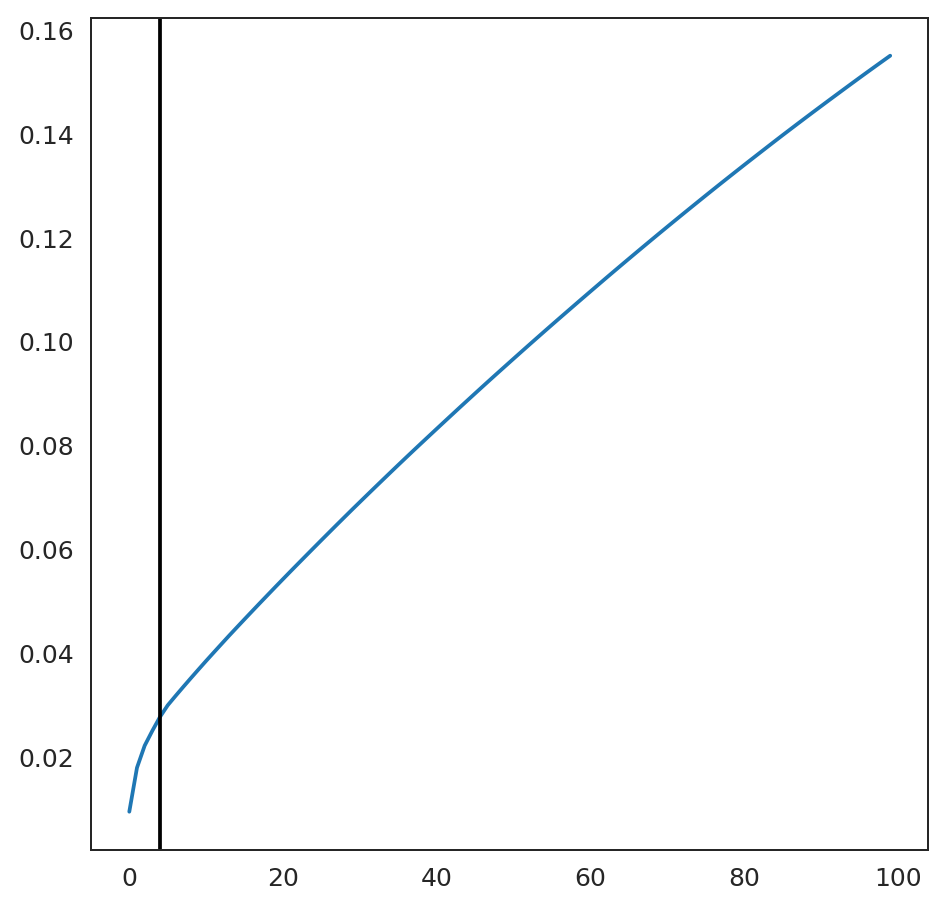

4


In [16]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [17]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :12475


In [18]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :311


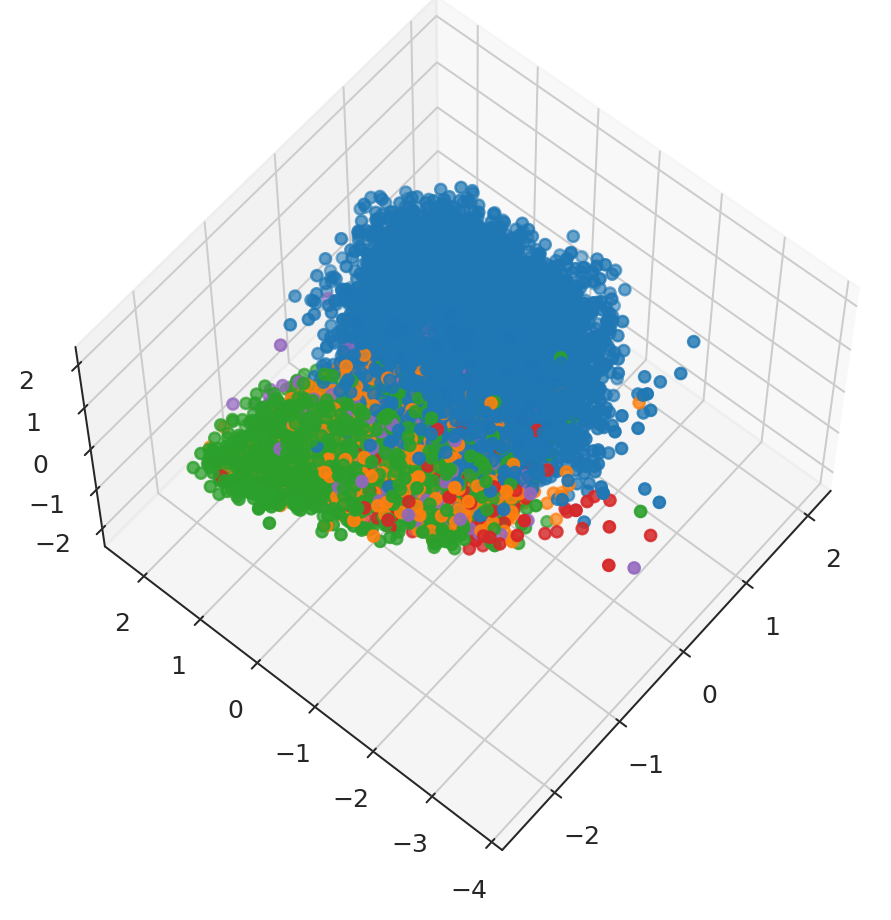

In [19]:
oracle.plot_pca()

In [20]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [21]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [22]:
adata.obsm['X_pca'].shape

(12475, 50)

In [23]:
adata.obs['rctd_cluster'].value_counts()

0    8550
2    1880
1    1342
4     360
3     343
Name: rctd_cluster, dtype: int64

In [24]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_cluster", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    n_jobs=8
)

  0%|          | 0/5 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/10168 [00:00<?, ?it/s]

In [ ]:
links.links_dict[0][links.links_dict[0].p < 0.05].query('target=="Il2"').reset_index(drop=True).sort_values(by='coef_mean', ascending=False)

In [ ]:
links.links_dict[0].query('target=="Il2ra"').reset_index(drop=True).sort_values(by='coef_mean', ascending=False)

In [ ]:
import pickle

with open('../data/slideseq/celloracle_links_day3_1.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [ ]:
import pickle

with open('/Users/koush/Projects/SpaceOracle/data/slideseq/celloracle_links_day3_1.pkl', 'rb') as f:
    links_day3_1 = pickle.load(f)

with open('/Users/koush/Projects/SpaceOracle/data/slideseq/celloracle_links_day3_2.pkl', 'rb') as f:
    links_day3_2 = pickle.load(f)

In [ ]:
regulators = pd.concat(
    [list(links_day3_1.values())[x].query('target=="Cd74" and p < 0.05')[['source', 'coef_mean']] 
        for x in range(len(links_day3_1))], axis=0)

In [ ]:
(regulators
    .groupby('source')
    .mean()
    .sort_values(by='coef_mean', ascending=False)).index.tolist()

In [ ]:
plt.rcParams["figure.figsize"] = [10, 4]
df.groupby('source').mean().plot(kind='bar')

In [ ]:
pd.DataFrame(
    [df2.set_index('target').loc[np.intersect1d(
        df1.target, df2.target)].coef_mean-df1.set_index('target').loc[
     np.intersect1d(df1.target, df2.target)].coef_mean]).T.sort_values(by='coef_mean', ascending=False)[:20]

In [ ]:
oracle = co.data.load_tutorial_oracle_object()

In [ ]:
oracle.adata.obs['paul15_clusters'].unique()

In [ ]:
oracle.adata

In [ ]:
mat = pd.read_csv("coef_matrix.csv", index_col=0)

In [ ]:
# oracle.TFdict

In [ ]:
np.intersect1d(mat.columns, list(oracle.TFdict.keys())).__len__()

In [ ]:
np.intersect1d(mat.columns, list(oracle.TFdict.keys()))

In [ ]:
mat['Zyx'][mat['Zyx'] > 0]

In [ ]:
np.intersect1d(mat.columns, oracle.TFdict['Zyx'])

In [ ]:
np.intersect1d(oracle.adata.var_names, oracle.TFdict['0610007L01Rik'])

In [ ]:
oracle.fit_GRN_for_simulation()